In [25]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

True

In [26]:
model = ChatGoogleGenerativeAI(model="models/gemini-flash-latest")
model_llama = ChatOllama(model="llama3")
model_qween = ChatOllama(model="qwen3:4b")
model_gema = ChatOllama(model="gemma3")


In [27]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="sentiment of the review")

In [28]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="the Category of issue mentioned in the review")
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description="The emotional tone expressed by the user")
    urgency: Literal["low","medium","high"] = Field(description="How urgent or Critical the issue appears to be")


In [29]:
structure_model_gema = model_gema.with_structured_output(SentimentSchema)
structure_model_llama = model_llama.with_structured_output(DiagnosisSchema)

In [30]:
# prompt = "What is the sentiment of the review? - The software is bad"
# response = structure_model_gema.invoke(prompt)
# print(response)

sentiment='negative'


In [32]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [33]:
def find_sentiment(state: ReviewState):
    prompt = f"For the following review find out the sentiment of\n {state['review']}"
    sentiment = structure_model_gema.invoke(prompt).sentiment
    return {'sentiment' : sentiment }

In [34]:
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review: \n\n
        {state['review']}.\n
        Also, kindly ask the user to leave feedback on our website."""
    response = model.invoke(prompt).content
    return { 'response' : response }

In [35]:
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review: \n\n {state['review']}.\n
        Return issue_type, tone, and urgency."""
    response = structure_model_llama.invoke(prompt)
    return { 'diagnosis' : response.model_dump() }

In [36]:
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant. The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as {diagnosis['urgency']}. \n\n Write an empathetic, helpful resolution message """
    response = model.invoke(prompt).content
    return { 'response' : response }


In [37]:
def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

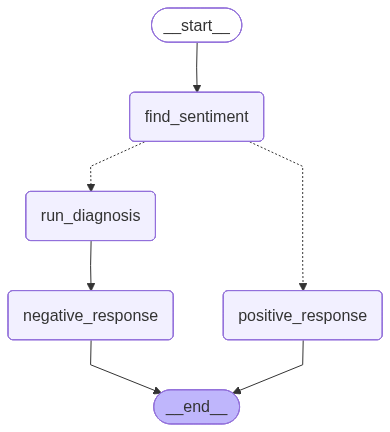

In [38]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)


workflow = graph.compile()
workflow

In [11]:
# inital_state = {
#     'review': 'The product was really good',
# }
#
# res = workflow.invoke(inital_state)
# res

{'review': 'The product was really good',
 'sentiment': SentimentSchema(sentiment='positive')}

In [24]:
postive_review_prompt = """I've been using this app for about a month now, and I must say the user interface clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial Great job to the design team! """

inital_state = {
    'review': postive_review_prompt,
}

res = workflow.invoke(inital_state)
res

{'review': "I've been using this app for about a month now, and I must say the user interface clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial Great job to the design team! ",
 'sentiment': SentimentSchema(sentiment='positive'),
 'diagnosis': {'issue_type': 'Performance', 'tone': 'calm', 'urgency': 'low'},
 'response': [{'type': 'text',
   'text': 'Subject: Resolution Confirmed: Update on the Recent Performance Issue\n\nDear [User Name],\n\nThank you for contacting us regarding the recent performance issue you experienced. We appreciate you taking the time to report this, and we especially value your calm and detailed approach, which allowed us to investigate the matter thoroughly.\n\nI understand that unexpected performance degradation can be frustrating, even when the urgency is low, as it impacts efficiency.\n\n### Resolution Summary:\n\nWe have completed our investigation and implemented a

In [39]:
negative_review_prompt = "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."

intial_state={
    'review': negative_review_prompt
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Support',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': 'Subject: Resolution Confirmed: Your High-Urgency Issue Regarding [Specific Topic/Feature]\n\nDear [User Name],\n\nThank you for reaching out to us and for making the urgency of this matter clear.\n\nPlease accept our most sincere apologies for the frustration and difficulty you experienced with [Briefly mention the issue, e.g., your account access, the broken feature, the delayed payment]. We absolutely understand that when an issue is marked as high urgency, immediate and effective resolution is critical, and we regret that this situation caused you stress.\n\n### **The Resolution**\n\nI am happy to confirm that the issu